In [46]:
import ipynb.fs.full.preProcessing as preProcess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
import json
import seaborn as sns

In [47]:
# Preparing the frame for training model
offences = preProcess.cleanedOffences
offences = offences.drop(columns=["Year ending", "Offence Count"])

communities = preProcess.cleanedCommunities
communities["Distance from Melbourne"] = np.sqrt(communities["Location_x"]**2 + communities["Location_y"]**2)
communities["Direction from Melbourne"] = np.arctan(communities["Location_x"]/ communities["Location_y"])

housingPrices = preProcess.cleanedHousingPrice
egm = preProcess.cleanedEgm

In [51]:
from sklearn.preprocessing import OneHotEncoder

SHIFT = 2
modelData = offences[(offences["Year"] >= 2014 + SHIFT) & (offences["Year"] <= 2021)]
modelData = pd.merge(left=modelData, right=communities, how="left", on="LGA")

for idx, row in modelData.iterrows():
    for shift in range(1, SHIFT + 1):
        modelData.loc[idx, "Last Offence Rate" + str(shift)] = offences[(offences["LGA"] == row["LGA"]) 
                                                & (offences["Year"] == row["Year"] - shift)]["Rate per 100,000 population"].iloc[0]
    # Housing can go 3 years backward
    for shift in range(1, SHIFT + 2):
        modelData.loc[idx, "Last Housing Price" + str(shift)] = housingPrices.loc[row["LGA"]][str(row["Year"] - shift)]
    # egm can go 5 years backward
    for shift in range(1, SHIFT + 4):
        modelData.loc[idx, "Last EGM" + str(shift)] = egm.loc[row["LGA"]][str(row["Year"] - shift)]

# Drop all except the time series one and LGA/Region
dropCol = []
for col in modelData.columns:
    flag = False
    for check in ["Last Offence Rate", "Last Housing Price", 
                  "Last EGM", "LGA", "Rate per 100,000 population", "Police Region"]:
        if check in col:
            flag = True
    if flag:
        continue
    dropCol.append(col)

modelData = modelData.drop(columns=dropCol)


# One hot the LGA - Use inverse transform from the encoder to get back the lga

oneHotEncoder = OneHotEncoder(handle_unknown='ignore').fit(np.array(modelData["LGA"]).reshape(-1, 1))
oneHotLGA = pd.DataFrame(oneHotEncoder
                         .transform(np.array(modelData["LGA"]).reshape(-1, 1))
                         .toarray())
renameCol = {}
for column in oneHotLGA.columns:
    renameCol[column] = "LGA" + str(column)
oneHotLGA = oneHotLGA.rename(columns=renameCol)
modelData = modelData.join(oneHotLGA)
modelData = modelData.drop(columns=["LGA"])

# One hot the region
oneHotEncoder = OneHotEncoder(handle_unknown='ignore').fit(np.array(modelData["Police Region"]).reshape(-1, 1))
oneHotRegion = pd.DataFrame(oneHotEncoder
                         .transform(np.array(modelData["Police Region"]).reshape(-1, 1))
                         .toarray())
renameCol = {}
for column in oneHotRegion.columns:
    renameCol[column] = "Region" + str(column)
oneHotRegion = oneHotRegion.rename(columns=renameCol)
modelData = modelData.join(oneHotRegion)
modelData = modelData.drop(columns=["Police Region"])

modelData.columns = modelData.columns.astype('str')

X = modelData.drop(columns=["Rate per 100,000 population"])
y = modelData["Rate per 100,000 population"]
# y = modelData["Rate per 100,000 population"] - modelData["Last Offence Rate1"]

modelData


,"Rate per 100,000 population",Last Offence Rate1,Last Offence Rate2,Last Housing Price1,Last EGM1,Last Housing Price2,Last EGM2,Last Housing Price3,Last EGM3,LGA0,...,LGA50,LGA51,LGA52,LGA53,LGA54,LGA55,Region0,Region1,Region2,Region3
0,5771.4,7257.4,7284.4,1.005577e+06,4.248559e+07,947589.088025,5.775811e+07,974188.646005,5.853691e+07,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,8642.6,9899.5,9571.5,6.758560e+05,1.019742e+08,649204.656587,1.429042e+08,671995.579062,1.395072e+08,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,8410.7,10020.0,9232.8,1.062963e+06,5.694230e+07,960093.130149,8.157611e+07,992230.276880,8.212961e+07,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,6320.8,6119.1,6496.7,8.938082e+05,3.461166e+07,866359.389987,4.704297e+07,901205.768852,4.743737e+07,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,7244.5,9026.3,9098.9,7.308673e+05,8.593511e+07,712070.907458,1.116959e+08,719526.264719,1.096238e+08,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,11925.1,11385.6,11044.5,1.995000e+05,2.564087e+07,187437.500000,2.470024e+07,177250.000000,2.482782e+07,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
332,7755.9,6857.1,6183.6,3.560000e+05,1.057564e+07,339500.000000,1.030988e+07,333625.000000,1.054645e+07,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
333,11633.5,9876.3,7947.7,1.590000e+05,1.003788e+07,158750.000000,1.035065e+07,151250.000000,1.014142e+07,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
334,4437.9,5198.3,4886.7,6.890000e+05,2.818480e+06,645600.000000,2.855820e+06,637800.000000,2.878671e+06,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [52]:
# Define models here
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression


DEPTH = 5

models = {
    "regressor": DecisionTreeRegressor(max_depth=DEPTH, random_state=1301267),
    "ada": AdaBoostRegressor(
        DecisionTreeRegressor(max_depth=DEPTH), n_estimators=400, random_state=1301266),
    "rf": RandomForestRegressor(n_estimators=500, max_depth=DEPTH),
    "gradBoost": GradientBoostingRegressor(n_estimators = 500,
        max_depth = 4,
        min_samples_split = 3,
        learning_rate = 0.01,
        loss = "squared_error"),
    "linear": LinearRegression()
}

In [53]:
def getSplitAttributes(tree_rules: str):
    # Parsing the split attributes
    splitAtts = []
    AttRegex = r".*\|--- ([^<>=]*) [<>=].*"

    for line in tree_rules.split("\n"):
        # print(line)
        matchObj = re.match(AttRegex, line)
        if matchObj:
            att = matchObj.group(1)
            splitAtts.append(att)
            # print(att)
    return splitAtts

MSE of null : 10757059.35551112
RMSE of null : 3274.9131616957875
MSE of null2 : 832926.0876470585
RMSE of null2 : 911.8496919520577
MSE of regressor : 1093525.9840394391
RMSE of regressor : 1045.7163773517577
MSE of ada : 966522.7526533881
RMSE of ada : 982.9194323313811
MSE of rf : 885918.3252602674
RMSE of rf : 940.754231842649
MSE of gradBoost : 992573.3866555628
RMSE of gradBoost : 994.2757051043532
MSE of linear : 604748.2433676701
RMSE of linear : 777.5385104239803
Used attributes for regressor tree: 
Last Offence Rate1     226
Last Offence Rate2     126
Last Housing Price1     50
Last EGM3               36
Last Housing Price2     30
Last EGM2               28
Last Housing Price3     26
Last EGM1               18
LGA27                    8
LGA4                     6
Region3                  4
LGA40                    4
LGA38                    2
LGA29                    2
LGA28                    2
LGA6                     2
Region1                  2
LGA19                    2


<Figure size 640x480 with 0 Axes>

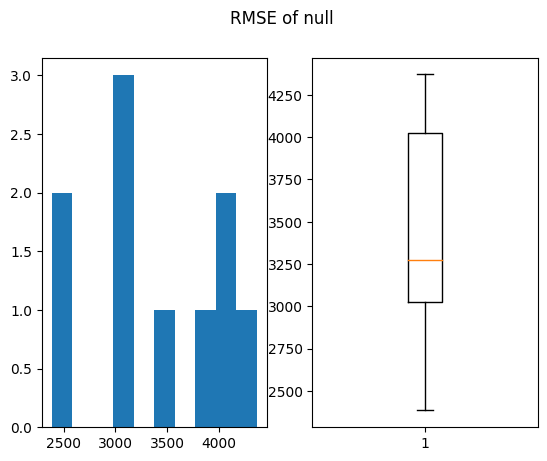

<Figure size 640x480 with 0 Axes>

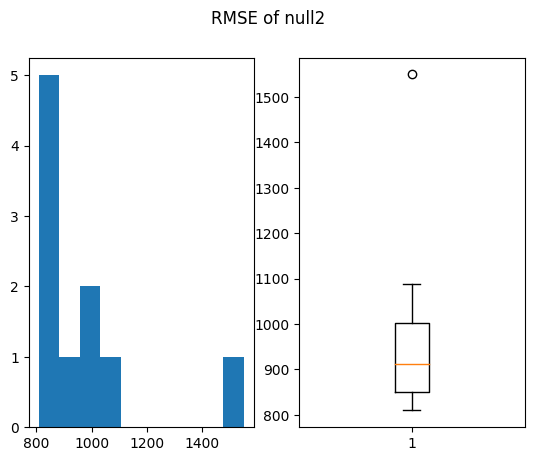

<Figure size 640x480 with 0 Axes>

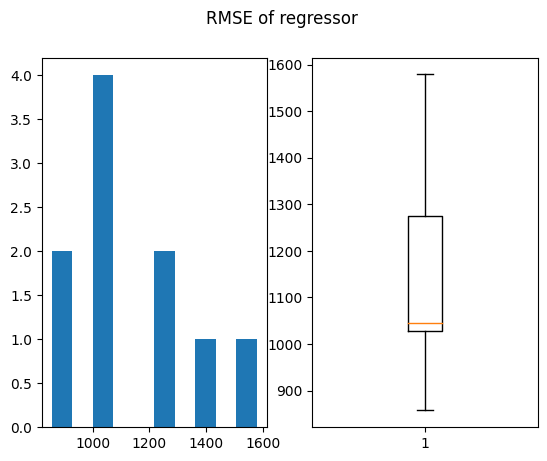

<Figure size 640x480 with 0 Axes>

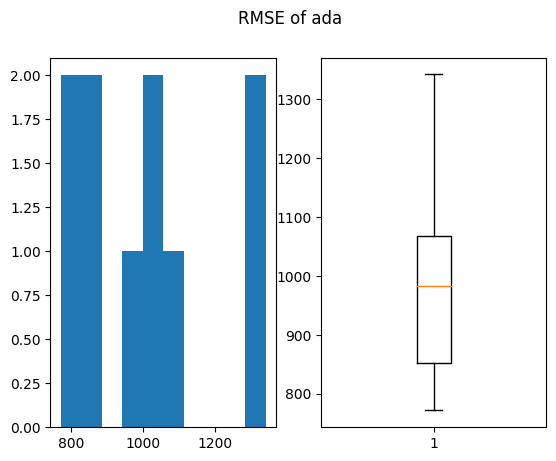

<Figure size 640x480 with 0 Axes>

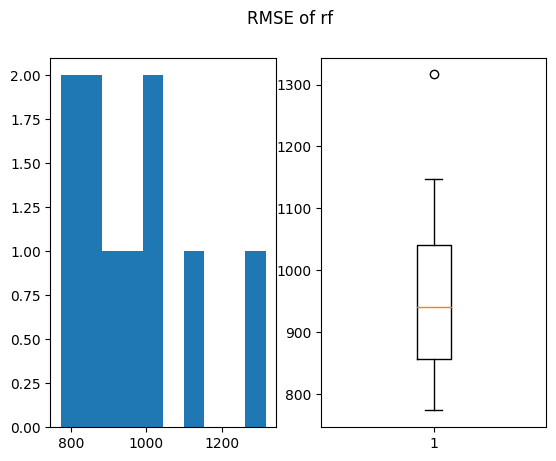

<Figure size 640x480 with 0 Axes>

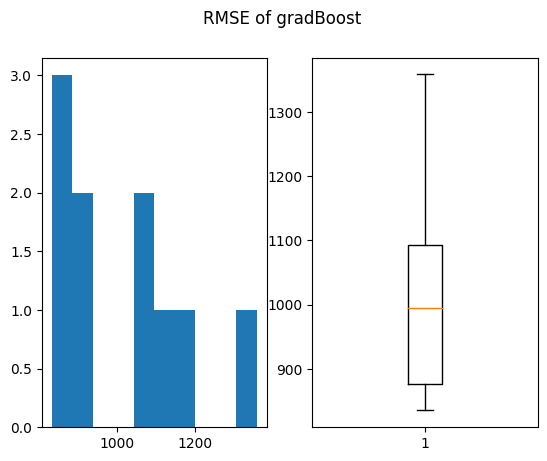

<Figure size 640x480 with 0 Axes>

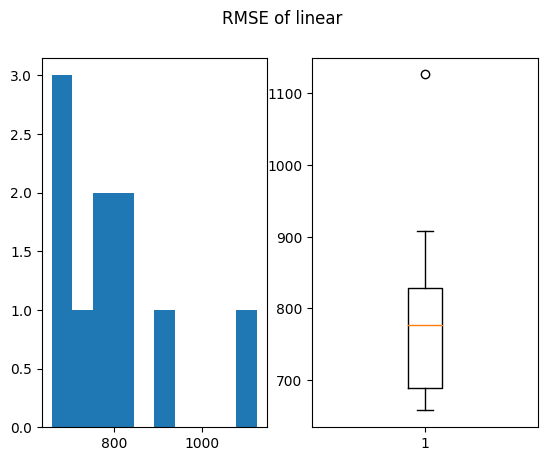

In [54]:
# Try restricting the input to only the top 10 highest NMI attribute from communities
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_text

n = 10

nf_CV = KFold(n_splits=n, shuffle=True, random_state=42)
mses = {
    "null": [],
    "null2": []
}

relavantAttributes = []


for train_idx, test_idx in nf_CV.split(X):
    # train-test split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    y_null_predict = [y_train.mean()] * len(X_test)

    predicts = {}
    for name in models:
        model = models[name]
        models[name] = model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        predicts[name] = y_predict

    mse_null = mean_squared_error(y_test, y_null_predict)
    mses["null"].append(mse_null)

    modelTest = modelData.loc[X_test.index]
    mse_null_2 = mean_squared_error(modelTest["Rate per 100,000 population"], modelTest["Last Offence Rate1"])
    mses["null2"].append(mse_null_2)

    for name in models:
        mse = mean_squared_error(predicts[name], y_test)
        if name not in mses:
            mses[name] = []
        mses[name].append(mse)


    # if (np.sqrt(mse_ada) > 2000):
    #     print(X_test)
    #     print(y_test)

    # Get the summary of all attributes
    tree_rules = export_text(models["regressor"], feature_names=list(X_train))
    relavantAttributes.extend(getSplitAttributes(tree_rules))

# Print the RMSE for each model
for key in mses:
    print("MSE of", key, ":", np.median(mses[key]))
    print("RMSE of", key, ":", np.median(np.sqrt(mses[key])))



print("Used attributes for regressor tree: ")
print(pd.Series(relavantAttributes).value_counts())



for name in mses:
    plt.figure()
    fig, axs = plt.subplots(1, 2)
    fig.suptitle("RMSE of " + name)
    axs[0].hist(np.sqrt(mses[name]))
    axs[1].boxplot(np.sqrt(mses[name]))
    plt.show()


    